In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from src.dataset import AminoAcidDataset, GraphAADataset
from src.model import GraphConvolutionalNetwork
from src.train import train_model, evaluate_model
from src.visual import plot_confusion_matrix, plot_aa_distributions

In [2]:
dataset = GraphAADataset('data/amino_acids_1_5A_augmented.pdb', padding=True)
print(f"Number of samples: {len(dataset)}")

Number of samples: 21291


In [3]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [4]:

"""    def __init__(
        self,
        node_fea_len: int,
        hidden_fea_len: int,
        n_conv: int,
        n_hidden: int,
        n_outputs: int,
        p_dropout: float = 0.0,
    ):"""
data_example  = dataset[0]
#model = GraphConvolutionalNetwork(
# get shape of data example
#print(data_example)
#print(data_example[0])


model = GraphConvolutionalNetwork(
    node_vec_len=7,  # Match input dimension
    node_fea_len=7,  # Match input dimension
    hidden_fea_len=32,
    n_conv=4,
    n_hidden=2,
    n_outputs=20,
    p_dropout=0.1
)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
n_epochs = 25
total_loss = []
epoch_lr = []
model.train()  # Set the model to training mode

# check if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    model.to(device)

for epoch in range(n_epochs):
        # Add batch dimension if needed
    model.train()
    epoch_loss = 0
    # Go over each batch in the dataloader
    for i, dataset in enumerate(train_dataloader):

        node_mat, adj_mat, residue = dataset
        dataset = (node_mat, adj_mat), residue
        # Unpack data
        node_mat = dataset[0][0]
        adj_mat = dataset[0][1]
        output = dataset[1]

        first_dim = int((torch.numel(node_mat)) / (14 * 7))
        node_mat = node_mat.reshape(first_dim, 14, 7)
        adj_mat = adj_mat.reshape(first_dim, 14, 14)

        nn_input = (node_mat, adj_mat)
        output = model(*nn_input)

        # Calculate the loss
        target = torch.argmax(residue, dim=1)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate the loss
        epoch_loss += loss.item()

    # Calculate the average loss for the epoch
    epoch_loss /= len(test_dataloader)
    total_loss.append(epoch_loss)
    epoch_lr.append(optimizer.param_groups[0]['lr'])

    # If the loss is not decreasing in the last 5 epochs, reduce the learning rate
    #if len(total_loss) > 5 and all(total_loss[-i] >= total_loss[-i-1] for i in range(1, 6)):
    #    for param_group in optimizer.param_groups:
    #        param_group['lr'] *= 0.5
    #        print(f'Reducing learning rate to {param_group["lr"]}')

    # If the loss is not decreasing in the last 10 epochs, stop training
    #if len(total_loss) > 10 and all(total_loss[-i] >= total_loss[-i-1] for i in range(1, 11)):
    #    print('Stopping training')
    #    break

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.5f}', end='\r')


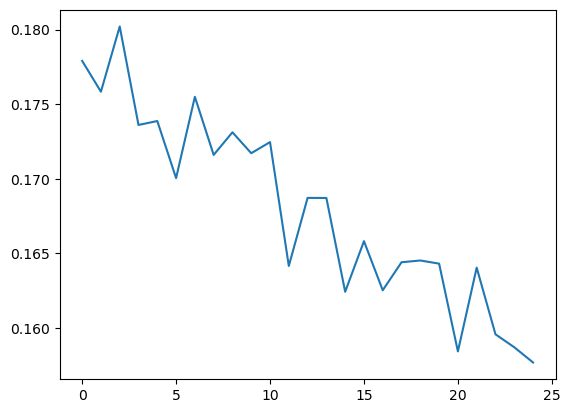

In [24]:
plt.plot(total_loss)

In [25]:
# torchmetrics accuracy

from torchmetrics import Accuracy

accuracy = Accuracy(task='MULTICLASS', num_classes=20) 

model.eval()

for i, dataset in enumerate(test_dataloader):
    node_mat, adj_mat, residue = dataset
    dataset = (node_mat, adj_mat), residue
    # Unpack data
    node_mat = dataset[0][0]
    adj_mat = dataset[0][1]
    output = dataset[1]

    first_dim = int((torch.numel(node_mat)) / (14 * 7))
    node_mat = node_mat.reshape(first_dim, 14, 7)
    adj_mat = adj_mat.reshape(first_dim, 14, 14)

    nn_input = (node_mat, adj_mat)
    output = model(*nn_input)

    # Calculate the loss
    target = torch.argmax(residue, dim=1)
    loss = criterion(output, target)

    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')


Accuracy: 0.9204038381576538


Text(47.222222222222214, 0.5, 'True')

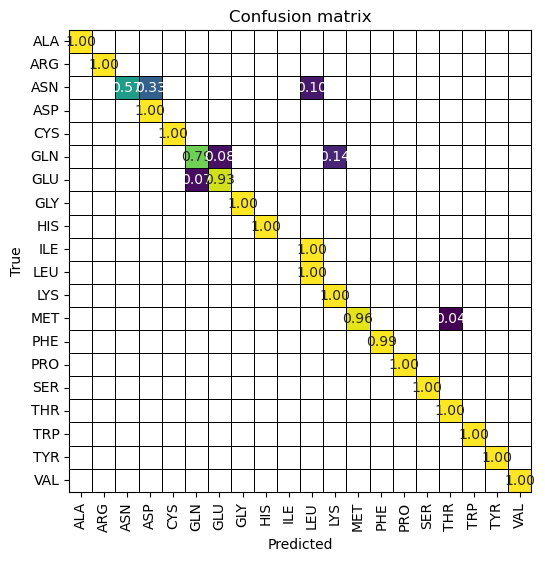

In [26]:
# get the confusion matrix
from torchmetrics import ConfusionMatrix
import seaborn as sns
import numpy as np


confusion_matrix = ConfusionMatrix(num_classes=20, task='MULTICLASS')

model.eval()

for i, dataset in enumerate(test_dataloader):
    node_mat, adj_mat, residue = dataset
    dataset = (node_mat, adj_mat), residue
    # Unpack data
    node_mat = dataset[0][0]
    adj_mat = dataset[0][1]
    output = dataset[1]

    first_dim = int((torch.numel(node_mat)) / (14 * 7))
    node_mat = node_mat.reshape(first_dim, 14, 7)
    adj_mat = adj_mat.reshape(first_dim, 14, 14)

    nn_input = (node_mat, adj_mat)
    output = model(*nn_input)

    # Calculate the loss
    target = torch.argmax(residue, dim=1)
    loss = criterion(output, target)

    confusion_matrix.update(output, target)
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
            'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
            'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
# Compute the confusion matrix and normalize it
confusion_matrix = confusion_matrix.compute().numpy()
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True) # Normalize the confusion matrix
confusion_matrix = np.where(confusion_matrix > 0.01, confusion_matrix, np.nan)  # Only show any values > 0.01
confusion_matrix = np.round(confusion_matrix, 2)

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix, square=True, annot=True, xticklabels=amino_acids, yticklabels=amino_acids, cmap='viridis', fmt='.2f', cbar=False, linewidths=0.5, linecolor='black')

for _, spine in ax.spines.items():
    spine.set_visible(True)

ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
